# Hands-on

- https://huggingface.co/learn/deep-rl-course/unit2/hands-on
- https://colab.research.google.com/github/huggingface/deep-rl-class/blob/main/notebooks/unit2/unit2.ipynb

### 🎮 Environments:

- [FrozenLake-v1](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)
- [Taxi-v3](https://gymnasium.farama.org/environments/toy_text/taxi/)

### 📚 RL-Library:

- Python and NumPy
- [Gymnasium](https://gymnasium.farama.org/)

## Objectives of this notebook 🏆

At the end of the notebook, you will:

- Be able to use **Gymnasium**, the environment library.
- Be able to code a Q-Learning agent from scratch.
- Be able to **push your trained agent and the code to the Hub** with a nice video replay and an evaluation score 🔥.

# Let's code our first Reinforcement Learning algorithm 🚀

We'll install multiple ones:

- `gymnasium`: Contains the FrozenLake-v1 ⛄ and Taxi-v3 🚕 environments.
- `pygame`: Used for the FrozenLake-v1 and Taxi-v3 UI.
- `numpy`: Used for handling our Q-table.

```
pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit2/requirements-unit2.txt

sudo apt update
sudo apt install -y python3-opengl
sudo apt apt install ffmpeg xvfb
pip install pyvirtualdisplay
```

## Import the packages 📦

In addition to the installed libraries, we also use:

- `random`: To generate random numbers (that will be useful for epsilon-greedy policy).
- `imageio`: To generate a replay video.

In [ ]:
import numpy as np
import gymnasium as gym
import random
import imageio
import os
import tqdm

import pickle5 as pickle
from tqdm.notebook import tqdm

# Part 1: Frozen Lake ⛄ (non slippery version)

## Create and understand [FrozenLake environment ⛄]((https://gymnasium.farama.org/environments/toy_text/frozen_lake/)
---

💡 A good habit when you start to use an environment is to check its documentation

👉 https://gymnasium.farama.org/environments/toy_text/frozen_lake/

---

We're going to train our Q-Learning agent **to navigate from the starting state (S) to the goal state (G) by walking only on frozen tiles (F) and avoid holes (H)**.

We can have two sizes of environment:

- `map_name="4x4"`: a 4x4 grid version
- `map_name="8x8"`: a 8x8 grid version


The environment has two modes:

- `is_slippery=False`: The agent always moves **in the intended direction** due to the non-slippery nature of the frozen lake (deterministic).
- `is_slippery=True`: The agent **may not always move in the intended direction** due to the slippery nature of the frozen lake (stochastic).

For now let's keep it simple with the 4x4 map and non-slippery.
We add a parameter called `render_mode` that specifies how the environment should be visualised. In our case because we **want to record a video of the environment at the end, we need to set render_mode to rgb_array**.

As [explained in the documentation](https://gymnasium.farama.org/api/env/#gymnasium.Env.render) “rgb_array”: Return a single frame representing the current state of the environment. A frame is a np.ndarray with shape (x, y, 3) representing RGB values for an x-by-y pixel image.

In [ ]:
# Create the FrozenLake-v1 environment using 4x4 map and non-slippery version and render_mode="rgb_array"
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")

### Let's see what the Environment looks like:

In [ ]:
# We create our environment with gym.make("<name_of_the_environment>")- `is_slippery=False`: The agent always moves in the intended direction due to the non-slippery nature of the frozen lake (deterministic).
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space Shape :", env.observation_space)
print("Observation Space Sample:", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

Observation Space Shape : Discrete(16)
Observation Space Sample: 6


We see with `Observation Space : Discrete(16)` that the observation is an integer representing the **agent’s current position as current_row * ncols + current_col (where both the row and col start at 0)**.

For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map. **For example, the 4x4 map has 16 possible observations.**


For instance, this is what state = 0 looks like:

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit2/frozenlake.png" alt="FrozenLake">

In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape :", env.action_space.n)
print("Action Space Sample:", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

Action Space Shape : 4
Action Space Sample: 2


The action space (the set of possible actions the agent can take) is discrete with 4 actions available 🎮:
- 0: GO LEFT
- 1: GO DOWN
- 2: GO RIGHT
- 3: GO UP

Reward function 💰:
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

## Create and Initialize the Q-table 🗄️

(👀 Step 1 of the pseudocode)

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/Q-learning-2.jpg" alt="Q-Learning" width="100%"/>


It's time to initialize our Q-table! To know how many rows (states) and columns (actions) to use, we need to know the action and observation space. We already know their values from before, but we'll want to obtain them programmatically so that our algorithm generalizes for different environments. Gym provides us a way to do that: `env.action_space.n` and `env.observation_space.n`


In [ ]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  16  possible states
There are  4  possible actions


In [ ]:
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

In [ ]:
Qtable_frozenlake = initialize_q_table(state_space, action_space)

In [ ]:
Qtable_frozenlake

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

## Define the greedy policy 🤖

Remember we have two policies since Q-Learning is an **off-policy** algorithm. This means we're using a **different policy for acting and updating the value function**.

- Epsilon-greedy policy (acting policy)
- Greedy-policy (updating policy)

The greedy policy will also be the final policy we'll have when the Q-learning agent completes training. The greedy policy is used to select an action using the Q-table.

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/off-on-4.jpg" alt="Q-Learning" width="100%"/>

In [ ]:
def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action = np.argmax(Qtable[state][:])

  return action

## Define the epsilon-greedy policy 🤖

Epsilon-greedy is the training policy that handles the exploration/exploitation trade-off.

The idea with epsilon-greedy:

- With *probability 1 - ɛ* : **we do exploitation** (i.e. our agent selects the action with the highest state-action pair value).

- With *probability ɛ*: we do **exploration** (trying a random action).

As the training continues, we progressively **reduce the epsilon value since we will need less and less exploration and more exploitation.**

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/Q-learning-4.jpg" alt="Q-Learning" width="100%"/>


In [ ]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  # Randomly generate a number between 0 and 1
  random_num = random.uniform(0, 1)
  # if random_num > greater than epsilon --> exploitation
  if random_num > epsilon:
    # Take the action with the highest value given a state
    action = greedy_policy(Qtable, state)
  # else --> exploration
  else:
    action = env.action_space.sample()

  return action

## Define the hyperparameters ⚙️

The exploration related hyperparamters are some of the most important ones.

- We need to make sure that our agent **explores enough of the state space** to learn a good value approximation. To do that, we need to have progressive decay of the epsilon.
- If you decrease epsilon too fast (too high decay_rate), **you take the risk that your agent will be stuck**, since your agent didn't explore enough of the state space and hence can't solve the problem.

In [ ]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
learning_rate = 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "FrozenLake-v1"     # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005           # Exponential decay rate for exploration prob

## Create the training loop method

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/Q-learning-2.jpg" alt="Q-Learning" width="100%"/>

The training loop goes like this:

```
For episode in the total of training episodes:

Reduce epsilon (since we need less and less exploration)
Reset the environment

  For step in max timesteps:    
    Choose the action At using epsilon greedy policy
    Take the action (a) and observe the outcome state(s') and reward (r)
    Update the Q-value Q(s,a) using Bellman equation Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
    If done, finish the episode
    Our next state is the new state
```

In [ ]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in tqdm(range(n_training_episodes)):
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state, info = env.reset()
    step = 0
    terminated = False
    truncated = False

    # repeat
    for step in range(max_steps):
      # Choose the action At using epsilon greedy policy
      action = epsilon_greedy_policy(Qtable, state, epsilon)

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, terminated, truncated, info = env.step(action)

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

      # If terminated or truncated finish the episode
      if terminated or truncated:
        break

      # Our next state is the new state
      state = new_state
  return Qtable

## Train the Q-Learning agent 🏃

In [ ]:
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

  0%|          | 0/10000 [00:00<?, ?it/s]

## Let's see what our Q-Learning table looks like now 👀

In [ ]:
Qtable_frozenlake

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77378053, 0.77378092],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

In [ ]:
state, info = env.reset()
images = [env.render()]
for step in range(max_steps):
    action = greedy_policy(Qtable_frozenlake, state)
    print(f"State: {state}, Action: {action}")
    new_state, reward, terminated, truncated, info = env.step(action)
    images.append(env.render())
    if terminated or truncated:
        break
    state = new_state

State: 0, Action: 1
State: 4, Action: 1
State: 8, Action: 2
State: 9, Action: 1
State: 13, Action: 2
State: 14, Action: 2


In [ ]:
len(images)

7

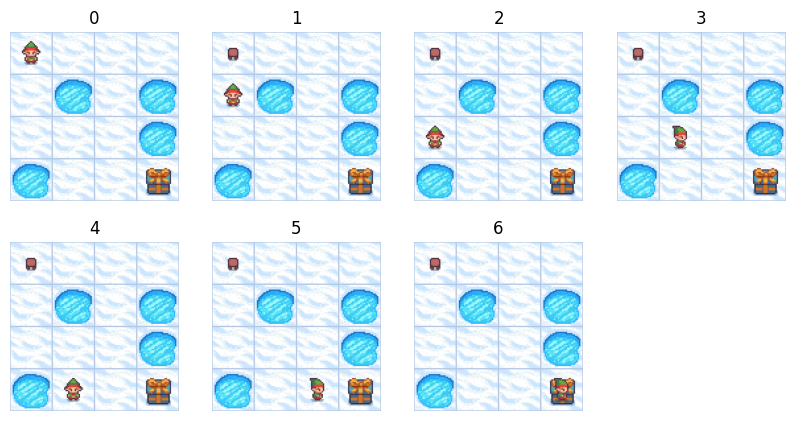

In [ ]:
fig = plt.figure(figsize=(10, 5))
axes = fig.subplots(nrows=2, ncols=4)
axes = axes.flatten()

for ax in axes:
    ax.axis('off')

for i in range(len(images)):
    axes[i].imshow(images[i])
    axes[i].set_title(i)

## The evaluation method 📝

- We defined the evaluation method that we're going to use to test our Q-Learning agent.

In [ ]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param max_steps: Maximum number of steps per episode
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  :param seed: The evaluation seed array (for taxi-v3)
  """
  episode_rewards = []
  for episode in tqdm(range(n_eval_episodes)):
    if seed:
      state, info = env.reset(seed=seed[episode])
    else:
      state, info = env.reset()
    step = 0
    truncated = False
    terminated = False
    total_rewards_ep = 0

    for step in range(max_steps):
      # Take the action (index) that have the maximum expected future reward given that state
      action = greedy_policy(Q, state)
      new_state, reward, terminated, truncated, info = env.step(action)
      total_rewards_ep += reward

      if terminated or truncated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

## Evaluate our Q-Learning agent 📈

- Usually, you should have a mean reward of 1.0
- The **environment is relatively easy** since the state space is really small (16). What you can try to do is [to replace it with the slippery version](https://gymnasium.farama.org/environments/toy_text/frozen_lake/), which introduces stochasticity, making the environment more complex.

In [ ]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean_reward=1.00 +/- 0.00


## Publish our trained model to the Hub 🔥

Now that we saw good results after the training, **we can publish our trained model to the Hub 🤗 with one line of code**.

Here's an example of a Model Card:

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit2/modelcard.png" alt="Model card" width="100%"/>

#### Do not modify this code

In [ ]:
from huggingface_hub import HfApi, snapshot_download
from huggingface_hub.repocard import metadata_eval_result, metadata_save

from pathlib import Path
import datetime
import json

In [ ]:
def record_video(env, Qtable, out_directory, fps=1):
  """
  Generate a replay video of the agent
  :param env
  :param Qtable: Qtable of our agent
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """
  images = []
  terminated = False
  truncated = False
  state, info = env.reset(seed=random.randint(0,500))
  img = env.render()
  images.append(img)
  while not terminated or truncated:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, terminated, truncated, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [ ]:
def push_to_hub(
    repo_id, model, env, video_fps=1, local_repo_path="hub"
):
    """
    Evaluate, Generate a video and Upload a model to Hugging Face Hub.
    This method does the complete pipeline:
    - It evaluates the model
    - It generates the model card
    - It generates a replay video of the agent
    - It pushes everything to the Hub

    :param repo_id: repo_id: id of the model repository from the Hugging Face Hub
    :param env
    :param video_fps: how many frame per seconds to record our video replay
    (with taxi-v3 and frozenlake-v1 we use 1)
    :param local_repo_path: where the local repository is
    """
    _, repo_name = repo_id.split("/")

    eval_env = env
    api = HfApi()

    # Step 1: Create the repo
    repo_url = api.create_repo(
        repo_id=repo_id,
        exist_ok=True,
    )

    # Step 2: Download files
    repo_local_path = Path(snapshot_download(repo_id=repo_id))

    # Step 3: Save the model
    if env.spec.kwargs.get("map_name"):
        model["map_name"] = env.spec.kwargs.get("map_name")
        if env.spec.kwargs.get("is_slippery", "") == False:
            model["slippery"] = False

    # Pickle the model
    with open((repo_local_path) / "q-learning.pkl", "wb") as f:
        pickle.dump(model, f)

    # Step 4: Evaluate the model and build JSON with evaluation metrics
    mean_reward, std_reward = evaluate_agent(
        eval_env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"]
    )

    evaluate_data = {
        "env_id": model["env_id"],
        "mean_reward": mean_reward,
        "n_eval_episodes": model["n_eval_episodes"],
        "eval_datetime": datetime.datetime.now().isoformat()
    }

    # Write a JSON file called "results.json" that will contain the
    # evaluation results
    with open(repo_local_path / "results.json", "w") as outfile:
        json.dump(evaluate_data, outfile)

    # Step 5: Create the model card
    env_name = model["env_id"]
    if env.spec.kwargs.get("map_name"):
        env_name += "-" + env.spec.kwargs.get("map_name")

    if env.spec.kwargs.get("is_slippery", "") == False:
        env_name += "-" + "no_slippery"

    metadata = {}
    metadata["tags"] = [env_name, "q-learning", "reinforcement-learning", "custom-implementation"]

    # Add metrics
    eval = metadata_eval_result(
        model_pretty_name=repo_name,
        task_pretty_name="reinforcement-learning",
        task_id="reinforcement-learning",
        metrics_pretty_name="mean_reward",
        metrics_id="mean_reward",
        metrics_value=f"{mean_reward:.2f} +/- {std_reward:.2f}",
        dataset_pretty_name=env_name,
        dataset_id=env_name,
    )

    # Merges both dictionaries
    metadata = {**metadata, **eval}

    model_card = f"""
  # **Q-Learning** Agent playing1 **{env_id}**
  This is a trained model of a **Q-Learning** agent playing **{env_id}** .

  ## Usage

  ```python

  model = load_from_hub(repo_id="{repo_id}", filename="q-learning.pkl")

  # Don't forget to check if you need to add additional attributes (is_slippery=False etc)
  env = gym.make(model["env_id"])
  ```
  """

    evaluate_agent(env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"])

    readme_path = repo_local_path / "README.md"
    readme = ""
    print(readme_path.exists())
    if readme_path.exists():
        with readme_path.open("r", encoding="utf8") as f:
            readme = f.read()
    else:
        readme = model_card

    with readme_path.open("w", encoding="utf-8") as f:
        f.write(readme)

    # Save our metrics to Readme metadata
    metadata_save(readme_path, metadata)

    # Step 6: Record a video
    video_path = repo_local_path / "replay.mp4"
    record_video(env, model["qtable"], video_path, video_fps)

    # Step 7. Push everything to the Hub
    api.upload_folder(
        repo_id=repo_id,
        folder_path=repo_local_path,
        path_in_repo=".",
    )

    print("Your model is pushed to the Hub. You can view your model here: ", repo_url)

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

We're now ready to push our trained agent to the 🤗 Hub 🔥 using `push_to_hub()` function

- Let's create **the model dictionary that contains the hyperparameters and the Q_table**.

In [ ]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,

    "learning_rate": learning_rate,
    "gamma": gamma,

    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,

    "qtable": Qtable_frozenlake
}

In [ ]:
model

{'env_id': 'FrozenLake-v1',
 'max_steps': 99,
 'n_training_episodes': 10000,
 'n_eval_episodes': 100,
 'eval_seed': [],
 'learning_rate': 0.7,
 'gamma': 0.95,
 'max_epsilon': 1.0,
 'min_epsilon': 0.05,
 'decay_rate': 0.0005,
 'qtable': array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
        [0.73509189, 0.        , 0.81450625, 0.77378094],
        [0.77378094, 0.857375  , 0.77378094, 0.81450625],
        [0.81450625, 0.        , 0.77378053, 0.77378092],
        [0.77378094, 0.81450625, 0.        , 0.73509189],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.9025    , 0.        , 0.81450625],
        [0.        , 0.        , 0.        , 0.        ],
        [0.81450625, 0.        , 0.857375  , 0.77378094],
        [0.81450625, 0.9025    , 0.9025    , 0.        ],
        [0.857375  , 0.95      , 0.        , 0.857375  ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.

Let's fill the `push_to_hub` function:

- `repo_id`: the name of the Hugging Face Hub Repository that will be created/updated `
(repo_id = {username}/{repo_name})`
💡 A good `repo_id` is `{username}/q-{env_id}`
- `model`: our model dictionary containing the hyperparameters and the Qtable.
- `env`: the environment.
- `commit_message`: message of the commit

In [ ]:
username = "mingyujeon" # FILL THIS
repo_name = "q-FrozenLake-v1-4x4-noSlippery"
push_to_hub(
    repo_id=f"{username}/{repo_name}",
    model=model,
    env=env)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

False


q-learning.pkl:   0%|          | 0.00/914 [00:00<?, ?B/s]

Your model is pushed to the Hub. You can view your model here:  https://huggingface.co/mingyujeon/q-FrozenLake-v1-4x4-noSlippery


# Part 2: Taxi-v3 🚖

## Create and understand [Taxi-v3 🚕](https://gymnasium.farama.org/environments/toy_text/taxi/)
---

💡 A good habit when you start to use an environment is to check its documentation

👉 https://gymnasium.farama.org/environments/toy_text/taxi/

---

In `Taxi-v3` 🚕, there are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue).

When the episode starts, **the taxi starts off at a random square** and the passenger is at a random location. The taxi drives to the passenger’s location, **picks up the passenger**, drives to the passenger’s destination (another one of the four specified locations), and then **drops off the passenger**. Once the passenger is dropped off, the episode ends.


<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit2/taxi.png" alt="Taxi">

In [ ]:
env = gym.make("Taxi-v3", render_mode="rgb_array")

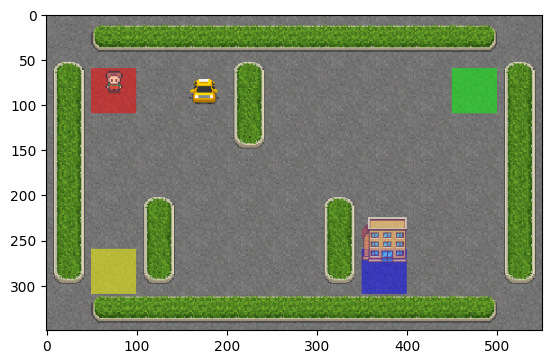

In [ ]:
env.reset()
plt.imshow(env.render())
plt.show()

There are **500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger** (including the case when the passenger is in the taxi), and **4 destination locations.**

In [ ]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

There are  500  possible states


In [ ]:
action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  6  possible actions


The action space (the set of possible actions the agent can take) is discrete with **6 actions available 🎮**:

- 0: move south
- 1: move north
- 2: move east
- 3: move west
- 4: pickup passenger
- 5: drop off passenger

Reward function 💰:

- -1 per step unless other reward is triggered.
- +20 delivering passenger.
- -10 executing “pickup” and “drop-off” actions illegally.

In [ ]:
# Create our Q table with state_size rows and action_size columns (500x6)
Qtable_taxi = initialize_q_table(state_space, action_space)
print(Qtable_taxi)
print("Q-table shape: ", Qtable_taxi .shape)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Q-table shape:  (500, 6)


## Define the hyperparameters ⚙️

⚠ DO NOT MODIFY EVAL_SEED: the eval_seed array **allows us to evaluate your agent with the same taxi starting positions for every classmate**

In [ ]:
# Training parameters
n_training_episodes = 25000   # Total training episodes
learning_rate = 0.7           # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# DO NOT MODIFY EVAL_SEED
eval_seed = [16,54,165,177,191,191,120,80,149,178,48,38,6,125,174,73,50,172,100,148,146,6,25,40,68,148,49,167,9,97,164,176,61,7,54,55,
 161,131,184,51,170,12,120,113,95,126,51,98,36,135,54,82,45,95,89,59,95,124,9,113,58,85,51,134,121,169,105,21,30,11,50,65,12,43,82,145,152,97,106,55,31,85,38,
 112,102,168,123,97,21,83,158,26,80,63,5,81,32,11,28,148] # Evaluation seed, this ensures that all classmates agents are trained on the same taxi starting position
                                                          # Each seed has a specific starting state

# Environment parameters
env_id = "Taxi-v3"           # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.005            # Exponential decay rate for exploration prob

## Train our Q-Learning agent 🏃

In [ ]:
Qtable_taxi = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_taxi)
Qtable_taxi

  0%|          | 0/25000 [00:00<?, ?it/s]

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  2.75200354,   3.94947615,   2.75200369,   3.94947757,
          5.20997639,  -5.05052244],
       [  7.93349184,   9.40367562,   7.93349167,   9.40367562,
         10.9512375 ,   0.40367562],
       ...,
       [ -2.85768123,  12.58025   ,   6.98118033,  -2.75399828,
         -9.5655    ,  -7.        ],
       [  4.94627492,   6.53681725,   4.27829112,  -4.2524189 ,
        -11.4450907 , -13.54438339],
       [ 11.06      ,  -1.3755    ,  -0.7       ,  18.        ,
         -9.1       ,   2.87      ]])

## Create a model dictionary 💾 and publish our trained model to the Hub 🔥

- We create a model dictionary that will contain all the training hyperparameters for reproducibility and the Q-Table.

In [ ]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,

    "learning_rate": learning_rate,
    "gamma": gamma,

    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,

    "qtable": Qtable_taxi
}

In [ ]:
username = "mingyujeon" # FILL THIS
repo_name = "q-Taxi-v3" # FILL THIS
push_to_hub(
    repo_id=f"{username}/{repo_name}",
    model=model,
    env=env)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


False


q-learning.pkl:   0%|          | 0.00/24.6k [00:00<?, ?B/s]

Your model is pushed to the Hub. You can view your model here:  https://huggingface.co/mingyujeon/q-Taxi-v3


In [ ]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_taxi, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean_reward=7.50 +/- 2.75


# Part 3: Load from Hub 🔽

What's amazing with Hugging Face Hub 🤗 is that you can easily load powerful models from the community.

Loading a saved model from the Hub is really easy:

1. You go https://huggingface.co/models?other=q-learning to see the list of all the q-learning saved models.
2. You select one and copy its repo_id

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit2/copy-id.png" alt="Copy id">

3. Then we just need to use `load_from_hub` with:
- The repo_id
- The filename: the saved model inside the repo.

#### Do not modify this code

In [ ]:
from urllib.error import HTTPError

from huggingface_hub import hf_hub_download


def load_from_hub(repo_id: str, filename: str) -> str:
    """
    Download a model from Hugging Face Hub.
    :param repo_id: id of the model repository from the Hugging Face Hub
    :param filename: name of the model zip file from the repository
    """
    # Get the model from the Hub, download and cache the model on your local disk
    pickle_model = hf_hub_download(
        repo_id=repo_id,
        filename=filename
    )

    with open(pickle_model, 'rb') as f:
      downloaded_model_file = pickle.load(f)

    return downloaded_model_file

In [ ]:
model = load_from_hub(repo_id="ThomasSimonini/q-Taxi-v3", filename="q-learning.pkl") # Try to use another model

print(model)
env = gym.make(model["env_id"])

evaluate_agent(env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"])

q-learning.pkl:   0%|          | 0.00/24.6k [00:00<?, ?B/s]

{'env_id': 'Taxi-v3', 'max_steps': 99, 'n_training_episodes': 25000, 'n_eval_episodes': 100, 'eval_seed': [16, 54, 165, 177, 191, 191, 120, 80, 149, 178, 48, 38, 6, 125, 174, 73, 50, 172, 100, 148, 146, 6, 25, 40, 68, 148, 49, 167, 9, 97, 164, 176, 61, 7, 54, 55, 161, 131, 184, 51, 170, 12, 120, 113, 95, 126, 51, 98, 36, 135, 54, 82, 45, 95, 89, 59, 95, 124, 9, 113, 58, 85, 51, 134, 121, 169, 105, 21, 30, 11, 50, 65, 12, 43, 82, 145, 152, 97, 106, 55, 31, 85, 38, 112, 102, 168, 123, 97, 21, 83, 158, 26, 80, 63, 5, 81, 32, 11, 28, 148], 'learning_rate': 0.7, 'gamma': 0.95, 'epsilon': 1.0, 'max_epsilon': 1.0, 'min_epsilon': 0.05, 'decay_rate': 0.005, 'qtable': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 2.75200369,  3.94947757,  2.75200369,  3.94947757,  5.20997639,
        -5.05052243],
       [ 7.93349184,  9.40367562,  7.93349184,  9.40367562, 10.9512375 ,
         0.40367562],
       ...,
       [10.9512375 , 12.58025   , 10

  0%|          | 0/100 [00:00<?, ?it/s]

(7.56, 2.706732347314747)